In [4]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
from IPython.display import Audio, display
import numpy as np

import os
# This is to force CPU evaluation since we probably train on a bigger GPU than I have
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import keras

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Get shared constants and functions
%run "NN Audio Core.py"

In [18]:
# Functions local to this notebook

# Only need this for testing at this point?  Could still make it a 'top' type shared function
def clip_frames(file):
    samples = get_samples(file)
    frames = np.empty((samples.shape[0], WINDOW_SIZE, FFT_BINS, 2))
    half_win = WINDOW_SIZE//2
    padded_samples = np.concatenate([np.zeros((half_win, FFT_BINS, 2)), samples, np.zeros((half_win, FFT_BINS, 2))])
    for i in range(0, samples.shape[0]-1):
        frames[i,:,:,:] = padded_samples[i:i+WINDOW_SIZE,:,:]
    return frames

def display_fft(ft):
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(ft), ref=np.max), y_axis='cqt_hz', x_axis='time')

def draw(wav):
    fft = get_ft(wav)
    display_fft(fft)
    return fft

In [16]:
# some test data to hack around with
test_file = "Assets\\DataShareArchive\\Test\\Clean\\p232_010.wav"
wav, rate = librosa.core.load(test_file)
ft = get_ft(wav)

In [9]:
#del model  # Just to be sure, since sometimes the errors didn't seem to change much on reload
model = keras.models.load_model("Best_cqt_model.h5")


Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [12]:
def diff_clip(wav_root, file):
    clean_dir = wav_root + "\\Clean\\"
    noisy_dir = wav_root + "\\Noisy\\"
    noisy_ft = get_ft_from_file(noisy_dir + file)
    clean_ft = get_ft_from_file(clean_dir + file)
    diff = diff_ft(clean_ft, noisy_ft)
    return diff


def clean_clip(model, n_file):
    verify_frames = clip_frames(n_file)
    output_targets = model.predict([verify_frames])
    wav, rate = librosa.core.load(n_file)
    n_fft = get_ft(wav)
    fft = rebuild_cqt(output_targets, n_fft)
    return fft, inv_ft(fft)

# For now just skipping below minimum files, which means we may not get exact count of results
def compare_files(wav_root, model, n_files=50, min_origin_diff=20):
    clean_dir = wav_root + "\\Clean\\"
    noisy_dir = wav_root + "\\Noisy\\"
    file_list = os.listdir(clean_dir)
    file_index = 0
    count = min(n_files, len(file_list))
    diff_ratios = np.empty((0,3))
    while (file_index < count) :
        file = file_list[file_index]
        #original_diff =30 + file_index
        noisy_ft = get_ft_from_file(noisy_dir + file)
        clean_ft = get_ft_from_file(clean_dir + file)
        original_diff = diff_ft(clean_ft, noisy_ft)
        if (original_diff > min_origin_diff):
            model_ft, wav = clean_clip(model, noisy_dir + file)
            model_diff = diff_ft(model_ft, clean_ft)
            #model_diff = 2 * file_index
            diff_ratios = np.append(diff_ratios,np.array([[original_diff,model_diff,model_diff/original_diff]]), axis=0)
            print("%s  :  original %3.2f  :  cleaned %3.2f  :  ratio %.2f" %(file, original_diff, model_diff, model_diff/original_diff))
        file_index += 1
    ratios = pd.Series(diff_ratios[:,2])
    print("\nRatios")
    print("Average: %.2f" % np.average(ratios))
    print("Percentiles")
    print(ratios.quantile([.25, .5, .75, .8, .9]))
    model_scores = pd.Series(diff_ratios[:,1])
    print("\nModel noise scores")
    print("Average: %.2f" % np.average(model_scores))
    print("Percentiles")
    print(model_scores.quantile([.25, .5, .75, .8, .9]))
    pr = pd.DataFrame(diff_ratios, columns=['Original', 'Cleaned', 'Ratio'])
    pr['Original'] = pd.cut(pr['Original'], bins=[0,50,100,150,200,250,300,500])
    pr.boxplot(by='Original', column=['Cleaned'])
    return pr

In [ ]:
dr = compare_files("Assets\\DataShareArchive\\Test\\", model, 40)

In [ ]:
dr.boxplot(by='Original', column=['Ratio'])

In [13]:
# Full round trip test
# "p232_005.wav" - nice train noise
file = "p232_005.wav"

path = "Assets\\DataShareArchive\\Test\\"

verify_file = path + "Noisy\\" + file
clean_file = path + "Clean\\" + file

p_fft, p_wav = clean_clip(model, verify_file)

wav, rate = librosa.core.load(clean_file)
c_fft = get_ft(wav)

cleaned_diff = diff_ft(p_fft, c_fft)
original_diff = diff_clip(path, file)
ratio = cleaned_diff / original_diff

print("Cleaned diff  %.2f" % cleaned_diff)
print("Original diff %.2f" % original_diff)
print("Ratio         %.2f" % ratio)

print("Cleaned clip")

display_fft(p_fft)
Audio(p_wav,rate=22050)

TypeError: rebuild_cqt() takes 1 positional argument but 2 were given

In [ ]:
wav, rate = librosa.core.load(verify_file)
n_fft = draw(wav)

err_fft = c_fft - n_fft
print("Average abs err vs clean = ", np.mean(abs(err_fft)))

print("Noisy file")
Audio(wav, rate=rate)

In [ ]:
cut_fft = n_fft-p_fft
display_fft(cut_fft)

print("Removed audio")
print("Average cut value = ", np.mean(abs(cut_fft)))

cut_wav = inv_ft(cut_fft)
Audio(cut_wav,rate=22050)


In [ ]:
wav, rate = librosa.core.load(clean_file)
c_fft = draw(wav)

print("Clean sample")
Audio(wav, rate=rate)

Verification of ability to rebuild clean from noisy clip and perfect clean magnitudes

0.0


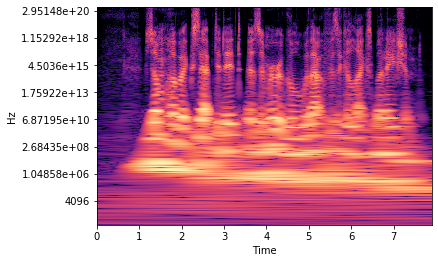

In [26]:
# Round trip test with no NN evaluation to test pipeline
# Have to get phase information from the noisy file to match what happens for real

file = "p232_013.wav"
test_file = "Assets\\DataShareArchive\\Test\\Clean\\" + file
noisy_file = "Assets\\DataShareArchive\\Test\\Noisy\\" + file
wav, rate = librosa.core.load(test_file)
noisy_wav, rate = librosa.core.load(noisy_file)

noisy_ft = get_ft(noisy_wav)
clean_ft = get_ft(wav)
samples = get_samples(test_file)

rt_ft = rebuild_cqt(samples)

rt_wav = inv_ft(rt_ft)

print(diff_ft(rt_ft, clean_ft))

display_fft(rt_ft)
Audio(rt_wav,rate=22050)

In [20]:
Audio(wav,rate=22050)